# Multi-Target Detection within Correlated Heavy-Tailed Clutter Using Alternating Convolutional kernels

## Imports

In [1]:
import torch
import wandb
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, ConcatDataset

In [2]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ari-granevich. Use `wandb login --relogin` to force relogin


True

## Dataset

### Explanation

#### Initialization
Input parameters:
* num_samples: Number of samples in the dataset.
* n_targets: Maximum number of targets per sample (default is 8).
* random_n_targets: If True, the number of targets per sample is random up to n_targets.
* nu: Parameter for the K-distributed clutter (shape parameter of the Gamma distribution).
* scnr: Signal-to-clutter-plus-noise ratio (SCNR) in dB for the targets.

Radar Parameters:
* N = 64: --------------------- Number of fast-time samples per pulse.
* K = 64: --------------------- Number of pulses per frame (slow-time samples).
* B = 50e6: ------------------- Chirp bandwidth (Hz).
* T0 = 1e-3: ------------------ Pulse repetition interval (PRI) in seconds.
* fc = 9.39e9: ---------------- Carrier frequency (Hz).
* c = 3e8: -------------------- Speed of light (m/s).
* CNR = 15: ------------------ Clutter-to-noise ratio in dB.
Range and Doppler Parameters:
* r_min, r_max = 0, 93: ------- Minimum and maximum range (meters).
* v_min, v_max = -7.7, 7.7: ---- Minimum and maximum Doppler velocities (m/s).
* vc_min, vc_max = -7.7, 7.7: -- Clutter velocity range (m/s).
* dr = 3: ---------------------- Range resolution (m).
* dv = 0.249: ----------------- Doppler resolution (m/s).

Range Bins: originaly 32

$$\mathbf{R} = \{ r_{\text{min}}, r_{\text{min}} + \Delta r, \dots, r_{\text{max}} \}$$

Doppler Bins: originaly 63

$$\mathbf{V} = \{ v_{\text{3min}}, v_{\text{min}} + \Delta v, \dots, v_{\text{max}} \}$$

Number of Range and Doppler Bins:
$$d_R = |\mathbf{R}|,\quad d_V = |\mathbf{V}|$$

Noise Power $\sigma^2$ :

$$\text{CNR}_{\text{linear}} = 10^{\frac{\text{CNR}_{\text{dB}}}{10}}$$

$$\sigma^2 = \frac{N}{2 \cdot \text{CNR}_{\text{linear}}}$$

Normalization Constant $\text{cn\_norm}$:

$$\text{cn\_norm} = \sqrt{N \cdot K \cdot \left( \frac{N}{2} + \sigma^2 \right)}$$

#### Generate target signal
1. Compute the range steering vector:
$$w_r = \frac{2 \pi \cdot 2 \cdot B \cdot \text{ranges}}{c \cdot N}$$

The range steering vector is then calculated as:

$$\text{range\_steering} = e^{-j \cdot w_r \cdot \text{arange}(N)}$$


2. Compute the velocity steering vector:
$$w_d = \frac{2 \pi \cdot T_0 \cdot 2 \cdot f_c \cdot \text{velocities}}{c}$$

The velocity steering vector is then calculated as:

$$\text{velocity\_steering} = e^{-j \cdot w_d \cdot \text{arange}(K)}$$

3. Combine the range and Doppler steering vectors:

$$ rd\_signal= range\_steering * velocity\_steering$$

Shape: $$Num\_targets \times N \times K$$

4. apply random phases for targets:

$$ rd\_signal = rd_signal * e^{j*phases}$$

5. prepare for scaling: Compute the norm of the signal for each target:

$$ S\_norm = ||rd_signal||$$

$$ sig\_amp = 10^{SCNR\_DB/20} \cdot \frac{cn\_norm}{S\_norm}$$

6. Scale and sum the signals for all targets into a single matrix:
$$
\text{rd\_signal} = \sum_{\text{targets}} \left( \text{sig\_amp} \cdot \text{rd\_signal} \right)
$$

7. The final output is a matrix:
$$
\text{rd\_signal} \in \mathbb{C}^{N \times K}
$$


#### Generate clutter

This function generates K-distributed SIRV (Spherically Invariant Random Vector) clutter using eigendecomposition.

The clutter velocity is sampled uniformly:
$$
\text{clutter\_vel} \sim U(\text{vc\_min}, \text{vc\_max})
$$

The Doppler shift of the clutter is computed as:
$$
f_d = \frac{2 \pi \cdot 2 \cdot f_c \cdot \text{clutter\_vel}}{c}
$$

The correlation matrix $ M $ is generated using:
$$
M_{p,q} = e^{\left(-2 \pi^2 \sigma_f^2 (p - q)^2 - j (p - q) f_d T_0 \right)}
$$
where $\sigma_f$ is a fixed parameter from the paper.

Complex Normal Samples


Generate complex normal samples $z$:
$$
z \sim \mathcal{CN}(0, \frac{1}{2})
$$
with shape $(K \times d_R)$.

Eigenvalue Decomposition:


Perform eigenvalue decomposition on  $M$:
$$
M = V \Lambda V^\dagger
$$

The square root of eigenvalues is computed:
$$
E = \text{diag}(\sqrt{\max(\lambda, 0)})
$$

The clutter time-domain weights are computed as:
$$
w_t = A z \quad \text{where } A = V E
$$

Texture Component:


The texture component $ s $ is sampled from a Gamma distribution:
$$
s \sim \text{Gamma}(\nu, \nu)
$$

Scale the clutter weights by the texture component:
$$
c_t = \sqrt{s} \cdot w_t
$$

Fast-Time × Slow-Time Representation:

The fast-time steering vector $c_{r\_steer}$ is computed as:
$$
c_{r\_steer} = \exp\left(-j \cdot 2 \pi \cdot \text{arange}(N) \cdot R \cdot \frac{2 B}{c \cdot N}\right)
$$

The final clutter matrix $C$ is obtained by:
$$
C = c_{r\_steer} \cdot c_t^T
$$


The function returns the clutter matrix $ C $:
$$
C \in \mathbb{C}^{N \times K}
$$


#### Generate frame and labels

This function generates a radar frame containing noise, clutter, and optionally targets, along with a label matrix identifying the target locations in the range-Doppler plane.

1. Generate Noise

   The noise matrix $ W $ is generated as:
   $$
   W \sim \mathcal{CN}\left(0, \frac{1}{2 \sigma^2}\right), \quad W \in \mathbb{C}^{N \times K}
   $$

2. Generate Clutter

   The clutter texture parameter $ \nu $ is sampled as:
   $$
   \nu \sim U(0.1, 1.5)
   $$  
   if $ \nu $ is not provided. Otherwise, it is set to the user-defined value.  
   The clutter matrix $ C $ is then generated using:
   $$
   C = \text{generate\_clutter}(\nu)
   $$

3. Initialize Target Signal and Label Matrices

   - Initialize the target signal matrix $ S $ with zeros:
     $$
     S = \mathbf{0}, \quad S \in \mathbb{C}^{N \times K}
     $$
   - Initialize the label matrix $ \text{rd\_label} $ with zeros:
     $$
     \text{rd\_label} = \mathbf{0}, \quad \text{rd\_label} \in \{0, 1\}^{d_R \times d_V}
     $$

4. Generate Targets (if applicable) 

   If targets are enabled, the following steps are performed:
   - Sample the number of targets $ n $:
     $$
     n \sim U(1, \text{n\_targets})
     $$  
     if $ \text{random\_n\_targets} $ is enabled. Otherwise, $ n $ is fixed to $ \text{n\_targets} $.
   - Sample the target ranges, velocities, phases, and SCNR values:
     $$
     \text{ranges} \sim U(r_\text{min}, r_\text{max})
     $$
     $$
     \text{velocities} \sim U(v_\text{min}, v_\text{max})
     $$
     $$
     \text{phases} \sim U(0, 2 \pi)
     $$
     $$
     \text{SCNR\_dBs} \sim U(-5, 10)
     $$  
     if $ \text{scnr} $ is not provided. Otherwise, SCNR is set to a constant value.

   - Generate the target signal matrix $ S $:
     $$
     S = \text{generate\_target\_signal}(\text{ranges}, \text{velocities}, \text{phases}, \text{SCNR\_dBs})
     $$

   - Populate the label matrix $ \text{rd\_label} $:  
     For each target, determine the nearest range bin $ r_\text{bin} $ and Doppler bin $ v_\text{bin} $:
     $$
     r_\text{bin} = \arg\min |R - r|, \quad v_\text{bin} = \arg\min |V - v|
     $$
     Set:
     $$
     \text{rd\_label}[r_\text{bin}, v_\text{bin}] = 1
     $$

5. Combine Signals

   The final radar frame $ X $ is the sum of the target signal, clutter, and noise:
   $$
   X = S + C + W
   $$

6. Return  

   The function returns:
   $$
   X \in \mathbb{C}^{N \times K}, \quad \text{rd\_label} \in \{0, 1\}^{d_R \times d_V}
   $$


### Original dataset Code

In [66]:
class RadarDataset(Dataset):
    def __init__(self, num_samples, n_targets: int = 8, random_n_targets=True, nu=None, scnr=None):
        super().__init__()
        self.num_samples = num_samples
        self.n_targets = n_targets
        self.random_n_targets = random_n_targets
        self.with_targets = n_targets > 0
        self.scnr = scnr
        self.nu = torch.tensor([nu]) if nu is not None else None

        # Parameters from Table II in the paper
        self.N = 64  # Samples per pulse (fast-time)
        self.K = 64  # Pulses per frame (slow-time)
        self.B = 50e6  # Chirp bandwidth (Hz)
        self.T0 = 1e-3  # PRI (s)
        self.fc = 9.39e9  # Carrier frequency (Hz)
        self.c = 3e8  # Speed of light (m/s)
        self.CNR = 15  # Clutter-to-noise ratio (dB)

        # Range and Doppler parameters
        self.r_min, self.r_max = 0, 93  # Range interval (m)
        self.v_min, self.v_max = -7.7, 7.7  # Doppler interval (m/s)
        self.vc_min, self.vc_max = -7.7, 7.7  # Clutter min/max velocity (m/s)
        self.dr = 3  # Range resolution (m)
        self.dv = 0.249  # Doppler resolution (m/s)

        # Calculate range and Doppler bins
        self.R = torch.arange(self.r_min, self.r_max + self.dr, self.dr)
        self.V = torch.arange(self.v_min, self.v_max + self.dv, self.dv)
        self.dR = len(self.R)  # Number of range bins
        self.dV = len(self.V)  # Number of Doppler bins
        #print(f"Range bins: {self.dR}, Doppler bins: {self.dV}")

        # Computes the noise power sigma^2 based on the given Clutter-to-Noise Ratio (CNR) 
        # converting from DB to linear scale - CNR_linear = 10^(CNR/10), then, sigma^2 = N / (2 * CNR_linear)
        self.sigma2 = self.N / (2 * 10 ** (self.CNR / 10)) 

        # Normalize the combined clutter and noise power.
        self.cn_norm = torch.sqrt(torch.tensor(self.N * self.K * (self.N // 2 + self.sigma2)))

    def generate_target_signal(self, ranges, velocities, phases, SCNR_dBs):
        """Generate target signal matrix"""
        # Range steering vector
        w_r = (2 * torch.pi * 2 * self.B * ranges) / (self.c * self.N)
        range_steering = torch.exp(-1j * torch.outer(w_r, torch.arange(self.N)))

        # Doppler steering vector
        w_d = (2 * torch.pi * self.T0 * 2 * self.fc * velocities) / self.c
        doppler_steering = torch.exp(-1j * torch.outer(w_d, torch.arange(self.K)))
        
        # Fast-time x Slow-time matrix
        rd_signal = range_steering.unsqueeze(-1) * doppler_steering.unsqueeze(1)

        # Random phase for each target
        rd_signal = rd_signal * torch.exp(1j * phases)

        # Scaling SCNR for each target
        S_norm = torch.linalg.norm(rd_signal, dim=(1, 2)).real
        sig_amp = (10 ** (SCNR_dBs / 20)) * (self.cn_norm / S_norm)
        # Expand sig_amp to have shape (N_range_bins, 1, 1) for broadcasting
        rd_signal = (sig_amp.unsqueeze(-1).unsqueeze(-1) * rd_signal).sum(dim=0)

        return rd_signal

    def generate_clutter(self, nu):
        """Generate K-distributed SIRV clutter using eigendecomposition"""
        # Clutter correlation matrix
        clutter_vel = torch.empty(1).uniform_(self.vc_min, self.vc_max)
        fd = (2 * torch.pi * (2 * self.fc * clutter_vel) / self.c)  # Clutter Doppler shift (m/s)
        sigma_f = 0.05  # From paper
        p, q = torch.meshgrid(torch.arange(self.N),
                              torch.arange(self.K), indexing='ij')

        # Generate complex correlation matrix
        M = torch.exp(-2 * torch.pi ** 2 * sigma_f ** 2 * (p - q) ** 2 - 1j * (p - q) * fd * self.T0)

        # Generate complex normal samples
        z = torch.randn(self.K, self.dR, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0))

        # Eigenvalue decomposition of the correlation matrix M
        e, V = torch.linalg.eigh(M)
        e_sqrt = torch.sqrt(torch.maximum(e.real, torch.tensor(0.0)))
        E = torch.diag(e_sqrt)
        A = V @ E.to(V.dtype)
        w_t = A @ z

        # Generate texture component
        s = torch.distributions.Gamma(nu, 1).sample((self.dR,))

        # Scale by texture component
        c_t = (torch.sqrt(s).unsqueeze(0) * w_t.unsqueeze(-1)).squeeze(-1)

        # Convert to fast-time × slow-time representation
        c_r_steer = torch.exp(-1j * 2 * torch.pi * torch.outer(torch.arange(self.N), self.R) *
                              (2 * self.B) / (self.c * self.N))
        C = c_r_steer @ c_t.transpose(0, 1)
        return C

    def gen_frame_and_labels(self):
        # Generate Noise
        #W = (torch.randn(self.N, self.K, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0 * self.sigma2)))
        sigma_dim = torch.sqrt(torch.tensor(self.sigma2) / 2)

        # Generate real and imaginary parts separately
        W_real = sigma_dim * torch.randn(self.N, self.K)
        W_imag = sigma_dim * torch.randn(self.N, self.K)

        # Combine into complex noise
        W = W_real + 1j * W_imag
        # Generate Clutter
        nu = torch.empty(1).uniform_(0.1, 1.5) if self.nu is None else self.nu
        C = self.generate_clutter(nu)
        # Initialize target signal and label matrices
        S = torch.zeros_like(W)
        rd_label = torch.zeros(self.dR, self.dV)
        if self.with_targets:
            n = torch.randint(1, self.n_targets + 1, (1,)) if self.random_n_targets else self.n_targets
            ranges = torch.empty(n).uniform_(self.r_min, self.r_max)
            velocities = torch.empty(n).uniform_(self.v_min, self.v_max)
            phases = torch.empty(n, 1, 1).uniform_(0, 2 * torch.pi)
            SCNR_dBs = torch.empty(n).uniform_(-5, 10) if self.scnr is None else self.scnr * torch.ones(n)
            S = self.generate_target_signal(ranges, velocities, phases, SCNR_dBs)

            # Create label matrix (Boolean matrix, label[i,j]= 1 if there is a target with range i and Doppler j
            for r, v in zip(ranges, velocities):
                r_bin = torch.argmin(torch.abs(self.R - r))
                v_bin = torch.argmin(torch.abs(self.V - v))
                rd_label[r_bin, v_bin] = True
        # Combine signals
        X = (S + C + W)
        return X, rd_label, C, W

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx: int):
        X, rd_label, C, W = self.gen_frame_and_labels()
        return X, rd_label, C, W


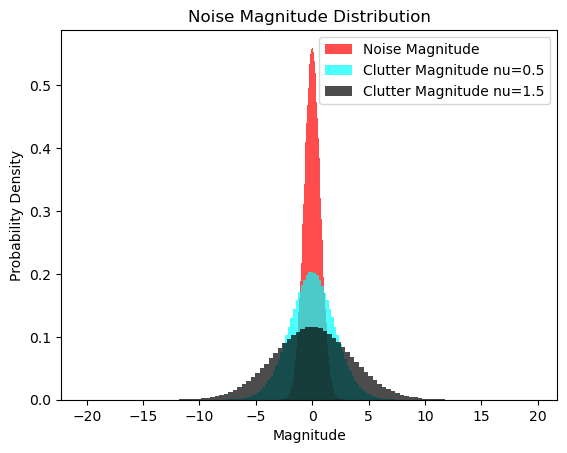

In [67]:
train_dataset_with_targets = RadarDataset(num_samples=10240, n_targets=8, random_n_targets=True,nu=0.5)
train_dataset_with_targets_nu = RadarDataset(num_samples=10240, n_targets=8, random_n_targets=True,nu=1.5)

num_samples = 1000
noise_real = []
noise_imag = []
noise_mag = []
clutter_real = []
clutter_imag = []
clutter_mag = []
clutter_nu =[]
for i in range(num_samples):
    X, rd_label, C, W = train_dataset_with_targets[i]

    noise_mag.extend(torch.real(W).flatten().numpy())
    clutter_mag.extend(torch.real(C).flatten().numpy())

for i in range(num_samples):
    X, rd_label, C, W = train_dataset_with_targets_nu[i]

    #noise_mag.extend(torch.real(W).flatten().numpy())
    clutter_nu.extend(torch.real(C).flatten().numpy())

# Set up the plotting environment
#plt.figure(figsize=(16, 12))


#plt.plot(2, 3, 3)
plt.hist(noise_mag, bins=100, density=True, alpha=0.7, color='red', label='Noise Magnitude')
plt.title('Noise Magnitude Distribution')
plt.xlabel('Magnitude')
plt.ylabel('Probability Density')
plt.legend()
#plt.show()

# Plot Clutter Magnitude Distribution (Real)
#plt.figure(figsize=(12, 8))
plt.hist(clutter_mag, bins=100, density=True, alpha=0.7, color='cyan', label='Clutter Magnitude nu=0.5')
plt.xlabel('Magnitude')
plt.ylabel('Probability Density')
plt.legend()
#plt.show()

# Plot Clutter Magnitude Distribution (Imaginary)
#plt.figure(figsize=(12, 8))
plt.hist(clutter_nu, bins=100, density=True, alpha=0.7, color='black', label='Clutter Magnitude nu=1.5')
plt.xlabel('Magnitude')
plt.ylabel('Probability Density')
plt.legend()
plt.show()


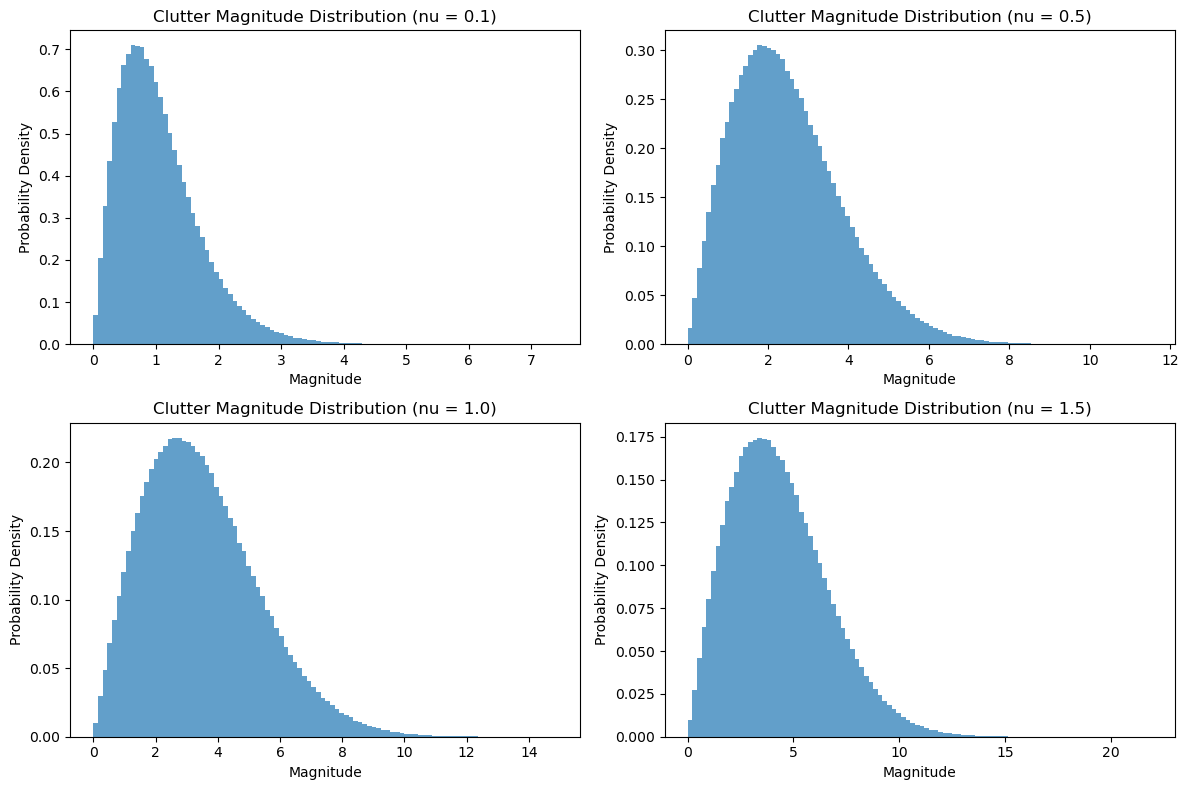

In [68]:
# List of nu values to test
nu_values = [0.1, 0.5, 1.0, 1.5]

# Initialize a dictionary to store clutter data for each nu
clutter_data_nu = {nu: [] for nu in nu_values}

# Number of samples per nu value
samples_per_nu = 250  # Adjust as needed

for nu in nu_values:
    # Set nu in the dataset
    train_dataset_with_targets.nu = torch.tensor([nu])
    
    for i in range(samples_per_nu):
        X, rd_label, C, W = train_dataset_with_targets[i]
        
        # Collect the magnitudes of the clutter
        clutter_mag = torch.abs(C).flatten().numpy()
        clutter_data_nu[nu].extend(clutter_mag)
# Plot the clutter distributions for different nu values
plt.figure(figsize=(12, 8))

for idx, nu in enumerate(nu_values):
    plt.subplot(2, 2, idx + 1)
    plt.hist(clutter_data_nu[nu], bins=100, density=True, alpha=0.7)
    plt.title(f'Clutter Magnitude Distribution (nu = {nu})')
    plt.xlabel('Magnitude')
    plt.ylabel('Probability Density')

plt.tight_layout()
plt.show()


### Range-Doppler Dataset

In [31]:
class RadarDataset(Dataset):
    def __init__(self, num_samples, n_targets: int = 8, random_n_targets=True, nu=None, scnr=None):
        super().__init__()
        self.num_samples = num_samples
        self.n_targets = n_targets
        self.random_n_targets = random_n_targets
        self.with_targets = n_targets > 0
        self.scnr = scnr
        self.nu = torch.tensor([nu]) if nu is not None else None

        # Parameters from Table II in the paper
        self.N = 64  # Samples per pulse (fast-time)
        self.K = 64  # Pulses per frame (slow-time)
        self.B = 50e6  # Chirp bandwidth (Hz)
        self.T0 = 1e-3  # PRI (s)
        self.fc = 9.39e9  # Carrier frequency (Hz)
        self.c = 3e8  # Speed of light (m/s)
        self.CNR = 15  # Clutter-to-noise ratio (dB)

        # Range and Doppler parameters
        self.r_min, self.r_max = 0, 93  # Range interval (m)
        self.v_min, self.v_max = -7.7, 7.7  # Doppler interval (m/s)
        self.vc_min, self.vc_max = -7.7, 7.7  # Clutter min/max velocity (m/s)
        self.dr = 3  # Range resolution (m)
        self.dv = 0.249  # Doppler resolution (m/s)

        # Calculate range and Doppler bins
        self.R = torch.arange(self.r_min, self.r_max + self.dr, self.dr)
        self.V = torch.arange(self.v_min, self.v_max + self.dv, self.dv)
        self.dR = len(self.R)  # Number of range bins
        self.dV = len(self.V)  # Number of Doppler bins

        # Computes the noise power sigma^2 based on the given Clutter-to-Noise Ratio (CNR)
        self.sigma2 = self.N / (2 * 10 ** (self.CNR / 10))

        # Normalize the combined clutter and noise power
        self.cn_norm = torch.sqrt(torch.tensor(self.N * self.K * (self.N // 2 + self.sigma2)))

        # Generate transmitted chirp signal (LFM waveform)
        self.t_fast = torch.linspace(0, self.T0, self.N)  # Fast-time sampling intervals
        self.tx_chirp = torch.exp(1j * torch.pi * self.B / self.T0 * self.t_fast ** 2)  # LFM chirp

    def generate_target_signal(self, ranges, velocities, phases, SCNR_dBs):
        """Generate target signal matrix"""
        # Range steering vector
        tau = 2 * ranges / self.c  # Time delay for each target
        w_r = 2 * torch.pi * self.B * tau / self.T0  # Frequency shift due to range
        range_steering = torch.exp(-1j * torch.outer(w_r, self.t_fast))

        # Doppler steering vector
        fd = 2 * velocities * self.fc / self.c  # Doppler frequency shift
        doppler_steering = torch.exp(1j * 2 * torch.pi * torch.outer(fd, torch.arange(self.K) * self.T0))

        # Fast-time x Slow-time matrix
        rd_signal = range_steering.unsqueeze(-1) * doppler_steering.unsqueeze(1)

        # Random phase for each target
        rd_signal = rd_signal * torch.exp(1j * phases)

        # Scaling SCNR for each target
        S_norm = torch.linalg.norm(rd_signal, dim=(1, 2)).real
        sig_amp = (10 ** (SCNR_dBs / 20)) * (self.cn_norm / S_norm)
        rd_signal = (sig_amp.unsqueeze(-1).unsqueeze(-1) * rd_signal).sum(dim=0)

        return rd_signal

    def generate_clutter(self, nu):
        """Generate K-distributed SIRV clutter using eigendecomposition"""
        # Clutter correlation matrix
        clutter_vel = torch.empty(1).uniform_(self.vc_min, self.vc_max)
        fd = 2 * clutter_vel * self.fc / self.c  # Clutter Doppler shift (Hz)
        sigma_f = 0.05  # From paper
        p, q = torch.meshgrid(torch.arange(self.N),
                              torch.arange(self.K), indexing='ij')

        # Generate complex correlation matrix
        M = torch.exp(-2 * torch.pi ** 2 * sigma_f ** 2 * (p - q) ** 2 - 1j * 2 * torch.pi * fd * self.T0 * (p - q))

        # Generate complex normal samples
        z = torch.randn(self.K, self.dR, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0))

        # Eigenvalue decomposition of the correlation matrix M
        e, V = torch.linalg.eigh(M)
        e_sqrt = torch.sqrt(torch.clamp(e.real, min=0.0))
        E = torch.diag(e_sqrt)
        A = V @ E.to(V.dtype)
        w_t = A @ z

        # Generate texture component
        s = torch.distributions.Gamma(nu, nu).sample((self.dR,))

        # Scale by texture component
        c_t = (torch.sqrt(s).unsqueeze(0) * w_t.unsqueeze(-1)).squeeze(-1)

        # Convert to fast-time × slow-time representation
        c_r_steer = torch.exp(-1j * 2 * torch.pi * torch.outer(torch.arange(self.N), self.R) *
                              (2 * self.B) / (self.c * self.N))
        C = c_r_steer @ c_t.transpose(0, 1)
        return C

    def gen_frame_and_labels(self):
        # Generate Noise
        W = (torch.randn(self.N, self.K, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0 * self.sigma2)))

        # Generate Clutter
        nu = torch.empty(1).uniform_(0.1, 1.5) if self.nu is None else self.nu
        C = self.generate_clutter(nu)

        # Initialize target signal and label matrices
        S = torch.zeros_like(W)
        rd_label = torch.zeros(self.dR, self.dV)
        if self.with_targets:
            n = torch.randint(1, self.n_targets + 1, (1,)) if self.random_n_targets else self.n_targets
            ranges = torch.empty(n).uniform_(self.r_min, self.r_max)
            velocities = torch.empty(n).uniform_(self.v_min, self.v_max)
            phases = torch.empty(n, 1, 1).uniform_(0, 2 * torch.pi)
            SCNR_dBs = torch.empty(n).uniform_(-5, 10) if self.scnr is None else self.scnr * torch.ones(n)
            S = self.generate_target_signal(ranges, velocities, phases, SCNR_dBs)

            # Create label matrix
            for r, v in zip(ranges, velocities):
                r_bin = torch.argmin(torch.abs(self.R - r))
                v_bin = torch.argmin(torch.abs(self.V - v))
                rd_label[r_bin, v_bin] = True

        # Combine signals
        X = (S + C + W)
        return X, rd_label

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx: int):
        X, rd_label = self.gen_frame_and_labels()

        matched_filter = torch.conj(self.tx_chirp)
        X_matched = torch.zeros_like(X, dtype=torch.cfloat)
        for k in range(self.K):
            X_matched[:, k] = torch.fft.ifft(torch.fft.fft(X[:, k]) * torch.fft.fft(matched_filter, n=self.N))

        # Doppler processing: FFT along slow-time (Doppler processing)
        RD_map = torch.fft.fftshift(torch.fft.fft(X_matched, dim=1), dim=1)

        # Take the magnitude squared to get the power
        RD_map_power = torch.abs(RD_map) ** 2

        return RD_map_power, rd_label


In [32]:
# Create datasets with and without targets
train_dataset_with_targets = RadarDataset(num_samples=10240, n_targets=8, random_n_targets=True)
train_dataset_no_targets = RadarDataset(num_samples=10240, n_targets=0)

val_dataset_with_targets = RadarDataset(num_samples=2048, n_targets=8, random_n_targets=True)
val_dataset_no_targets = RadarDataset(num_samples=2048, n_targets=0)

# Combine datasets
train_dataset = ConcatDataset([train_dataset_with_targets, train_dataset_no_targets])
val_dataset = ConcatDataset([val_dataset_with_targets, val_dataset_no_targets])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2,
                            pin_memory=torch.cuda.is_available(), persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True, num_workers=2,
                        pin_memory=torch.cuda.is_available(), persistent_workers=True)

Slow time x Fast time shape: torch.Size([64, 64])
Label shape: torch.Size([32, 63])


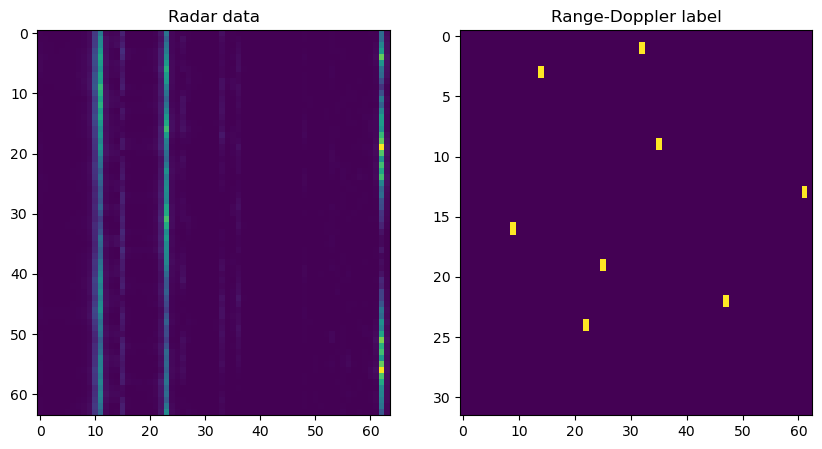

In [33]:
X, rd_label = train_dataset_with_targets[1]
print('Slow time x Fast time shape:', X.shape)
print('Label shape:', rd_label.shape)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(torch.abs(X), aspect='auto')
plt.title('Radar data')
plt.subplot(1, 2, 2)
plt.imshow(rd_label, aspect='auto')
plt.title('Range-Doppler label')
plt.show()


## Preprocessing

In [ ]:
class RadarPreprocessing(nn.Module):
    def __init__(self, detection_type: str = "range"):
        """
        Preprocessing module as described in Section III.B

        Args:
            detection_type: Either "range" or "doppler"
        """
        super().__init__()
        self.detection_type = detection_type

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # X shape: (batch, N, K, 2) - real and imaginary parts stacked in last dimension
        assert X.dtype == torch.complex64 or X.dtype == torch.complex128
        # Step 1: Reshape input based on detection type
        if self.detection_type == "range":
            X_0 = X.transpose(1, 2)  # (batch, K, N)
        else:  # doppler
            X_0 = X  # (batch, N, K)
        # Step 2: Center features over rows
        X_mean = torch.mean(X_0, dim=1, keepdim=True)
        X_1 = X_0 - X_mean
        # Step 3: Concatenate real and imaginary terms
        Z_0 = torch.cat([X_1.real, X_1.imag], dim=-1)  # (batch, K/N, 2*N/K)
        return Z_0

## DAFC Block From The Original Paper

In [ ]:
class DAFCBlock(nn.Module):
    def __init__(self, H: int, W: int, H_out: int, W_out: int):
        """
        Dimensional-Alternating Fully Connected Block

        Args:
            H: Input height
            W: Input width
            H_out: Output height
            W_out: Output width
        """
        super().__init__()

        # Row mapping layer (F transform)
        self.row_fc = nn.Linear(W, W_out)

        # Column mapping layer (G transform)
        self.col_fc = nn.Linear(H, H_out)

        # Activation functions
        self.hr = nn.Tanh()
        self.hc = nn.Tanh()

    def forward(self, Z_in: torch.Tensor) -> torch.Tensor:
        Z_in = Z_in.float()
        batch_size = Z_in.size(0)
        H = Z_in.size(1)

        # Step 1: FC transform of each row
        # Reshaping is necessary to apply nn.Linear
        Z_reshaped = Z_in.reshape(-1, Z_in.size(-1))  # (batch*H, W)

        Z_r = self.hr(self.row_fc(Z_reshaped))  # (batch*H, W_out)

        # Reshaping back to normal after applying nn.Linear
        Z_r = Z_r.reshape(batch_size, H, -1)  # (batch, H, W_out)

        # Step 2: FC transform of each column
        Z_r = Z_r.transpose(1, 2)  # (batch, W_out, H)
        Z_r = Z_r.contiguous()  # Make memory contiguous after transpose

        # Reshaping is necessary to apply nn.Linear
        Z_reshaped = Z_r.reshape(-1, Z_r.size(-1))  # (batch*W_out, H)

        Z_out = self.hc(self.col_fc(Z_reshaped))  # (batch*W_out, H_out)

        # Reshaping back to normal after applying nn.Linear
        Z_out = Z_out.reshape(batch_size, -1, Z_out.size(-1))  # (batch, W_out, H_out)

        Z_out = Z_out.transpose(1, 2)  # (batch, H_out, W_out)

        return Z_out


class DAFCRadarNet(nn.Module):
    def __init__(self, detection_type: str = "range"):
        """
        DAFC-based Radar Detection Network

        Args:
            detection_type: Either "range" or "doppler"
        """
        super().__init__()

        # Parameters from Table I
        if detection_type == "range":
            self.input_dim = (64, 128)  # (K, 2*N)
        else:  # doppler
            self.input_dim = (64, 128)  # (N, 2*K)

        # Preprocessing
        self.preprocess = RadarPreprocessing(detection_type)

        # DAFC blocks (dimensions from Table I)
        self.dafc1 = DAFCBlock(self.input_dim[0], self.input_dim[1], 128, 1024)
        self.dafc2 = DAFCBlock(128, 1024, 16, 256)
        self.dafc3 = DAFCBlock(16, 256, 4, 128)

        # Final FC layer
        fc_input_size = 4 * 128
        self.fc = nn.Linear(fc_input_size, 32 if detection_type == "range" else 63)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # Preprocessing
        Z_0 = self.preprocess(X)
        # DAFC blocks
        Z_1 = self.dafc1(Z_0)
        Z_2 = self.dafc2(Z_1)
        Z_3 = self.dafc3(Z_2)

        # Flatten and final FC layer
        Z_flat = Z_3.reshape(Z_3.size(0), -1)
        y = self.sigmoid(self.fc(Z_flat))

        return y
    


## New Model - Convolutions

In [ ]:
class ConvRadarNet(nn.Module):
    def __init__(self, detection_type: str = "range"):
        """
        Convolution-based Radar Detection Network

        Args:
            detection_type: Either "range" or "doppler"
        """
        super().__init__()

        # Parameters from Table I
        if detection_type == "range":
            self.input_dim = (64, 128)  # (K, 2*N)
        else:  # doppler
            self.input_dim = (64, 128)  # (N, 2*K)

        # Preprocessing
        self.preprocess = RadarPreprocessing(detection_type)

        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )  # Output: (16, 32, 64)

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )  # Output: (32, 16, 32)

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )  # Output: (64, 8, 16)

        # Fully connected layers
        fc_input_size = 64 * 8 * 16
        self.fc1 = nn.Linear(fc_input_size, 128)
        self.fc2 = nn.Linear(128, 32 if detection_type == "range" else 63)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # Preprocessing
        Z_0 = self.preprocess(X)  # (batch, H, W)

        # Add channel dimension for convolutional layers
        Z_0 = Z_0.unsqueeze(1)  # (batch, 1, H, W)

        # Convolutional layers
        Z_1 = self.conv1(Z_0)
        Z_2 = self.conv2(Z_1)
        Z_3 = self.conv3(Z_2)

        # Flatten and fully connected layers
        Z_flat = Z_3.view(Z_3.size(0), -1)
        Z_fc1 = nn.ReLU()(self.fc1(Z_flat))
        y = self.sigmoid(self.fc2(Z_fc1))

        return y
        

## Custom Loss Function

In [ ]:
class CBBCE(nn.Module):
    def __init__(self, ratio: float, beta: float = 0.99):
        """
        Class-Balanced Binary Cross Entropy Loss

        Args:
            ratio: Ratio of positive samples in dataset
            (number of targets in the dataset / number of bins in the dataset)
            beta: Beta parameter for class balancing
        """
        super().__init__()
        self.weight1 = (1 - beta) / (1 - beta ** ratio)
        print("w1: ", self.weight1)

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        """
        Forward pass

        Args:
            y_pred: Predicted values [batch, dim] (after sigmoid)
            y_true: True values [batch, dim]
        """
        _nll2 = F.binary_cross_entropy(y_pred, y_true, reduction='none')
        # Find indices where y_true >= 0.9999
        ind1 = (y_true >= 0.9999).nonzero(as_tuple=False)  # Shape: [N, 2]

        # Gather the loss values at these indices
        _nll_subset = self.weight1 * _nll2[ind1[:, 0], ind1[:, 1]]

        # Update the original loss tensor using scatter_
        _nll2 = _nll2.index_put_((ind1[:, 0], ind1[:, 1]), _nll_subset)

        # Return the mean of the updated loss tensor
        loss = torch.mean(_nll2)
        return loss


In [ ]:
def calculate_ratio(train_loader, detection_type):
    """Calculate ratio of positive samples in dataset from 2D labels"""
    n1 = 0  # target samples
    n_total = len(train_loader.dataset)
    n_total *= 32 if detection_type == 'range' else 63
    for _, rd_label in train_loader:
        # Get 1D labels by summing across appropriate dimension
        label = (rd_label.sum(dim=-1 if detection_type == "range" else -2) >= 1).float()
        # Count bins with targets
        n1 += torch.sum(label >= 0.9999)
    ratio = n1.item() / n_total
    print("ratio:", ratio, ", n1:", n1.item(), ", n_total:", n_total)
    return ratio


In [ ]:
def plot_training_history(history: dict, detection_type: str):
    """Plot training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15.12, 9.82))

    # Plot loss
    ax1.plot(history["train_loss"], label="Train")
    ax1.plot(history["val_loss"], label="Validation")
    ax1.set_title(f"{detection_type} Detector Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)

    # Plot accuracy
    ax2.plot(history["train_accuracy"], label="Train")
    ax2.plot(history["val_accuracy"], label="Validation")
    ax2.set_title(f"{detection_type} Detector Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(f"{detection_type}_training_history.png")
    plt.close()

In [ ]:
def train_model(model, criterion, train_loader, val_loader, detection_type, epochs=300, learning_rate=1e-3,
                weight_decay=5e-4):
    """
    Train range or Doppler detector

    Args:
        model: Neural network model
        criterion: Loss function
        train_loader: Training data loader
        val_loader: Validation data loader
        detection_type: "range" or "doppler"
        epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        weight_decay: Weight decay for optimizer
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move model to device
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.905, patience=5)
    # Check the last computed learning rate
    print(f"Last computed LR: {scheduler.get_last_lr()[0]}")

    # Training history
    history = {"train_loss": [], "val_loss": [], "train_accuracy": [], "val_accuracy": []}

    # Early stopping setup
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0
    best_model_state = None
    epoch_pbar = tqdm(range(epochs), desc="Training Progress")
    for epoch in epoch_pbar:
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for X, rd_label in train_loader:
            # Get input and label
            X = X.to(device)
            rd_label = rd_label.to(device)

            # Preprocess input and get 1D label
            label = (rd_label.sum(dim=-1 if detection_type == "range" else -2) >= 1).float()

            # Forward pass
            outputs = model(X)
            loss = criterion(outputs, label)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Statistics
            train_loss += loss.item()
            predictions = (outputs > 0).float()
            train_correct += (predictions == label).float().sum().item()
            train_total += label.numel()

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for X, rd_label in val_loader:
                # Get input and label
                X = X.to(device)
                rd_label = rd_label.to(device)

                # Preprocess input and get 1D label
                label = (rd_label.sum(dim=-1 if detection_type == "range" else -2) >= 1).float()

                # Forward pass
                outputs = model(X)
                loss = criterion(outputs, label)

                # Statistics
                val_loss += loss.item()
                predictions = (outputs > 0).float()
                val_correct += (predictions == label).float().sum().item()
                val_total += label.numel()

        # Calculate epoch metrics
        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_train_acc = train_correct / train_total
        epoch_val_acc = val_correct / val_total

        # Update history
        history["train_loss"].append(epoch_train_loss)
        history["val_loss"].append(epoch_val_loss)
        history["train_accuracy"].append(epoch_train_acc)
        history["val_accuracy"].append(epoch_val_acc)

        # Learning rate scheduling
        scheduler.step(epoch_val_loss)

        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs")
                break

        # Print epoch results
        print(f"\nEpoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Save model
    torch.save(model.state_dict(), f"{detection_type}_model.pt")

    return history

In [ ]:
# Train range detector
print("\nTraining Range Detector:")
detection_type = "range"
ratio = calculate_ratio(train_loader, detection_type)
criterion = CBBCE(ratio)
range_model = DAFCRadarNet(detection_type)
range_history = train_model(range_model, criterion, train_loader, val_loader, detection_type)
plot_training_history(range_history, "Range")

# Train Doppler detector
detection_type = "doppler"
ratio = calculate_ratio(train_loader, detection_type)
criterion = CBBCE(ratio)
print("\nTraining Doppler Detector:")
doppler_model = DAFCRadarNet(detection_type)
doppler_history = train_model(doppler_model, criterion, train_loader, val_loader, detection_type)
plot_training_history(doppler_history, "Doppler")

In [ ]:
class CombinedRadarTester:
    def __init__(self, range_model: nn.Module, doppler_model: nn.Module, device: torch.device):
        """Initialize combined radar tester"""
        self.range_model = range_model.to(device)
        self.doppler_model = doppler_model.to(device)
        self.device = device
        self.R = generate_range_steering_matrix().to(device)
        self.V = generate_doppler_steering_matrix().to(device)

    def feed_forward(self, loader: DataLoader) -> tuple:
        """Run models once and get all predictions"""
        self.range_model.eval()
        self.doppler_model.eval()

        all_Y_r = []
        all_Y_v = []
        all_X_rv_proj = []
        all_Y_true = []

        with torch.no_grad():
            for X, Y in loader:
                X = X.to(self.device)

                # Get range and Doppler predictions
                Y_r = self.range_model(X)
                Y_v = self.doppler_model(X)

                # Get range-Doppler projection
                Z = torch.abs(self.R.H @ X @ self.V.conj())

                all_Y_r.append(Y_r)
                all_Y_v.append(Y_v)
                all_X_rv_proj.append(Z)
                all_Y_true.append(Y.to(self.device))

        # Concatenate all batches
        Y_r = torch.cat(all_Y_r, dim=0)
        Y_v = torch.cat(all_Y_v, dim=0)
        X_rv_proj = torch.cat(all_X_rv_proj, dim=0)
        Y_true = torch.cat(all_Y_true, dim=0)

        return Y_r, Y_v, X_rv_proj, Y_true

    @staticmethod
    def predict(Y_r: torch.Tensor, Y_v: torch.Tensor, X_rv_proj: torch.Tensor, threshold: float) -> torch.Tensor:
        """Apply threshold to predictions to get detections"""
        # Thresholding
        Y_r_binary = (Y_r > threshold).float()
        Y_v_binary = (Y_v > threshold).float()

        # Combine range and Doppler detections
        Y_rv = Y_r.unsqueeze(-1) @ Y_v.unsqueeze(-2)
        Y_rv_binary = Y_r_binary.unsqueeze(-1) @ Y_v_binary.unsqueeze(-2)

        # Final decision matrix
        U = X_rv_proj * Y_rv * Y_rv_binary
        Y_hat = (U / U.max() > threshold).float()

        return Y_hat

    def get_metrics(self, Y_hat: torch.Tensor, Y_true: torch.Tensor) -> dict:
        """Evaluate detection performance for full dataset at once"""
        # Create the neighborhood kernel for 2D convolution
        kernel = torch.ones(1, 1, 3, 3, device=self.device)

        # Extend Y_hat and Y_true for convolution
        Y_hat_expanded = Y_hat.unsqueeze(1).float()  # [B, 1, H, W]
        Y_true_expanded = Y_true.unsqueeze(1).float()  # [B, 1, H, W]

        # Get extended matrices through convolution
        Y_true_extended = F.conv2d(Y_true_expanded, kernel, padding=1).squeeze(1)
        Y_true_extended = (Y_true_extended > 0)

        # Calculate PFA: Exclude target neighborhoods
        valid_cells = (~Y_true_extended).float()  # Cells not in target neighborhoods
        false_alarms = (Y_hat * valid_cells).sum()
        total_valid_cells = valid_cells.sum()
        Pfa = false_alarms.item() / total_valid_cells.item()

        # For PD: count targets and successful detections
        n_targets = Y_true.sum(dim=(1, 2))  # [B]

        # Get hits using extended Y_hat
        Y_hat_extended = F.conv2d(Y_hat_expanded, kernel, padding=1).squeeze(1)
        Y_hat_extended = (Y_hat_extended > 0).float()

        detected = (Y_hat_extended * Y_true).sum(dim=(1, 2))  # [B]

        # Calculate PD (if no targets, count as PD=1)
        Pd = torch.where(n_targets > 0, detected / n_targets, torch.ones_like(n_targets, dtype=torch.float32))
        Pd = Pd.mean().item()

        return {"Pd": Pd, "Pfa": Pfa}

    def find_threshold(self, loader: DataLoader, target_pfa: float) -> float:
        """Find threshold for target PFA using binary search"""
        # Get all predictions once
        Y_r, Y_v, X_rv_proj, Y_true = self.feed_forward(loader)

        th = 0.5  # Start at 0.5
        step = 0.5
        cnt = 1
        pfa_res = 1.0
        rel_err = abs(pfa_res - target_pfa) / abs(target_pfa)

        while rel_err >= 0.01 and cnt < 20:
            Y_hat = self.predict(Y_r, Y_v, X_rv_proj, th)
            metrics = self.get_metrics(Y_hat, Y_true)

            pfa_res = metrics["Pfa"]
            rel_err = abs(pfa_res - target_pfa) / abs(target_pfa)

            step = step * 0.5
            if pfa_res > target_pfa:
                th += step
            else:
                th -= step

            cnt += 1

        print(f"Found threshold = {th:.4f}, PFA = {pfa_res:.6f} after {cnt} iterations")
        return th

    def evaluate_pd_pfa(self, nu: float, scnr: float = 0) -> tuple:
        test_dataset_with_targets = RadarDataset(4096, n_targets=4, random_n_targets=False, nu=nu, scnr=scnr)
        test_dataset_no_targets = RadarDataset(2048, n_targets=0, random_n_targets=False, nu=nu, scnr=scnr)
        test_dataset = ConcatDataset([test_dataset_with_targets, test_dataset_no_targets])
        test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=2,
                              pin_memory=torch.cuda.is_available(), persistent_workers=True)
        
        Y_r, Y_v, X_rv_proj, Y_true = self.feed_forward(test_loader)
        
        # Store results for different target PFAs
        results = []
        target_pFAs = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]

        for target_pfa in tqdm(target_pFAs, desc="Testing PFAs"):
            # Use existing find_threshold method
            th = self.find_threshold(test_loader, target_pfa)
            Y_hat = self.predict(Y_r, Y_v, X_rv_proj, th)
            metrics = self.get_metrics(Y_hat, Y_true)
            results.append((metrics["Pd"], metrics["Pfa"]))
        
        pd_list, pfa_list = zip(*results)
        return np.array(pd_list), np.array(pfa_list)
        
    def evaluate_pd_scnr(self, nu: float, target_pfa: float = 5e-4) -> tuple:
        """Evaluate PD vs SCNR for fixed PFA"""
        # First find threshold using a reference dataset (SCNR = 0)
        ref_dataset_with_targets = RadarDataset(4096, n_targets=4, random_n_targets=False, nu=nu, scnr=0)
        ref_dataset_no_targets = RadarDataset(2048, n_targets=0, random_n_targets=False, nu=nu)
        ref_dataset = ConcatDataset([ref_dataset_with_targets, ref_dataset_no_targets])
        ref_loader = DataLoader(ref_dataset, batch_size=256, shuffle=True, num_workers=2,
                              pin_memory=torch.cuda.is_available(), persistent_workers=True)

        # Find threshold using binary search
        th = self.find_threshold(ref_loader, target_pfa)

        # Now evaluate for different SCNR values
        results = []
        scnr_range = np.arange(-30, 21, 5)

        for scnr in tqdm(scnr_range, desc="Testing SCNR values"):
            # Create dataset for this SCNR
            test_dataset_with_targets = RadarDataset(4096, n_targets=4, random_n_targets=False, nu=nu, scnr=scnr)
            test_dataset_no_targets = RadarDataset(2048, n_targets=0, random_n_targets=False, nu=nu, scnr=scnr)
            test_dataset = ConcatDataset([test_dataset_with_targets, test_dataset_no_targets])
            test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=2,
                              pin_memory=torch.cuda.is_available(), persistent_workers=True)

            # Get predictions
            Y_r, Y_v, X_rv_proj, Y_true = self.feed_forward(test_loader)

            # Evaluate using found threshold
            Y_hat = self.predict(Y_r, Y_v, X_rv_proj, th)
            metrics = self.get_metrics(Y_hat, Y_true)

            results.append((metrics["Pd"], metrics["Pfa"]))

        pd_list, pfa_list = zip(*results)
        return np.array(pd_list), np.array(pfa_list), scnr_range


def plot_pd_pfa(results: dict, save_path: str = 'pd_pfa.png'):
    """Plot PD vs PFA curves for different nu values"""
    plt.figure(figsize=(15.12, 9.82))

    for nu in results.keys():
        pd, pfa = results[nu]
        plt.plot(pfa, pd, label=f'ν = {nu}')

    plt.xlabel('Probability of False Alarm')
    plt.ylabel('Probability of Detection')
    plt.title('ROC Curves for Different Clutter Conditions')
    plt.grid(True)
    plt.legend()
    plt.xscale('log')
    plt.savefig(save_path)
    plt.close()


def plot_pd_scnr(results: dict, save_path: str = 'pd_scnr.png'):
    """Plot PD vs SCNR curves for different nu values"""
    plt.figure(figsize=(15.12, 9.82))

    for nu in results.keys():
        pd, pfa, scnr = results[nu]
        plt.plot(scnr, pd, label=f'ν = {nu}')

    plt.xlabel('SCNR (dB)')
    plt.ylabel('Probability of Detection')
    plt.title('Detection Performance vs SCNR')
    plt.grid(True)
    plt.legend()
    plt.savefig(save_path)
    plt.close()


def load_trained_models():
    """Load trained range and Doppler models"""
    range_model = DAFCRadarNet(detection_type="range")
    doppler_model = DAFCRadarNet(detection_type="doppler")

    try:
        range_model.load_state_dict(torch.load('range_model.pt', weights_only=True))
        print("Loaded range model successfully")
    except FileNotFoundError:
        print("Range model not found. Please train the model first.")
        return None, None

    try:
        doppler_model.load_state_dict(torch.load('doppler_model.pt', weights_only=True))
        print("Loaded doppler model successfully")
    except FileNotFoundError:
        print("Doppler model not found. Please train the model first.")
        return None, None

    range_model.eval()
    doppler_model.eval()

    return range_model, doppler_model


def generate_range_steering_matrix(N=64, dR=32, B=50e6, c=3e8):
    rng_res = c / (2 * B)
    r_vals = torch.arange(dR) * rng_res
    n_vals = torch.arange(N)

    phase = -1j * 2 * torch.pi * (2 * B) / (c * N)
    R = torch.exp(phase * torch.outer(n_vals, r_vals))

    return R


def generate_doppler_steering_matrix(K=64, dV=63, fc=9.39e9, T0=1e-3, c=3e8):
    vel_res = c / (2 * fc * K * T0)
    v_vals = torch.linspace(-dV // 2, dV // 2, dV) * vel_res
    k_vals = torch.arange(K)

    phase = -1j * 2 * torch.pi * (2 * fc * T0) / c
    V = torch.exp(phase * torch.outer(k_vals, v_vals))

    return V


def test():
    """Run complete test suite"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("using device: ", device)
    range_model, doppler_model = load_trained_models()
    tester = CombinedRadarTester(range_model, doppler_model, device)

    # Test parameters
    nu_values = [0.2, 0.5, 1.0]

    # PD vs PFA test (SCNR = 0dB)
    pd_pfa_results = {}
    print("Running PD vs PFA test...")
    for nu in tqdm(nu_values, desc="Testing clutter conditions"):
        pd, pfa = tester.evaluate_pd_pfa(nu, scnr=0)
        pd_pfa_results[nu] = (pd, pfa)
    plot_pd_pfa(pd_pfa_results)

    # PD vs SCNR test (PFA = 5e-4)
    pd_scnr_results = {}
    print("\nRunning PD vs SCNR test...")
    for nu in tqdm(nu_values, desc="Testing clutter conditions"):
        pd, pfa, scnr = tester.evaluate_pd_scnr(nu)
        pd_scnr_results[nu] = (pd, pfa, scnr)
    plot_pd_scnr(pd_scnr_results)

    return pd_pfa_results, pd_scnr_results
